In [1]:
%load_ext autoreload
%autoreload 2
from config import MARKET_MODEL_DIR,MARKET_MODEL_DIR_TESTING
from model_factory import build_market_neutral_model, build_market_neutral_model_testing
import pickle
with open(MARKET_MODEL_DIR, "rb") as f:
    params = pickle.load(f)

with open(MARKET_MODEL_DIR_TESTING, "rb") as f:
    params_testing = pickle.load(f)
    
import os
#个人许可证
#os.environ['GRB_LICENSE_FILE'] = os.path.expanduser("~/gurobi/gurobi.lic")


# ## 系统Gurobi
os.environ['GUROBI_HOME'] = '/usr/licensed/gurobi/12.0.0/linux64'
os.environ['GRB_LICENSE_FILE'] = '/usr/licensed/gurobi/license/gurobi.lic'

# 清除个人WLS许可证
for var in ['WLSACCESSID', 'WLSSECRET']:
    if var in os.environ:
        del os.environ[var]

model = build_market_neutral_model(**params)
model_testing= build_market_neutral_model_testing(**params_testing)

Using device: cuda
GPU: NVIDIA A100 80GB PCIe MIG 1g.10gb
Set parameter LicenseID to value 197246
Set parameter GURO_PAR_SPECIAL
Set parameter TokenServer to value "license.rc.princeton.edu"


In [2]:
print( params_testing)

{'N': 7, 'A': array([[1., 1., 1., 1., 1., 1., 1.]]), 'b': array([0.]), 'l': array([0., 0., 0., 0., 0., 0., 0.]), 'u': array([1000000., 1000000., 1000000., 1000000., 1000000., 1000000.,
       1000000.]), 'risk_f': array([0.35320865, 0.42288222, 0.37707359, 0.35261655, 0.41933761,
       0.32860565, 0.38218537]), 'risk_abs': 1.5, 'single_abs': 0.1, 'l1_abs': 1.0, 'cov_matrix': array([[4.67496276e-05, 4.15905709e-05, 3.60928100e-05, 3.48342604e-05,
        4.16919822e-05, 3.34891585e-05, 3.66772287e-05],
       [4.15905709e-05, 5.97804688e-05, 4.37975936e-05, 4.19857337e-05,
        5.10524222e-05, 3.90648444e-05, 4.49568886e-05],
       [3.60928100e-05, 4.37975936e-05, 5.26604548e-05, 3.92702956e-05,
        4.44118365e-05, 3.45134604e-05, 3.79007596e-05],
       [3.48342604e-05, 4.19857337e-05, 3.92702956e-05, 4.25771017e-05,
        4.21567423e-05, 3.38763419e-05, 3.56807453e-05],
       [4.16919822e-05, 5.10524222e-05, 4.44118365e-05, 4.21567423e-05,
        5.69786874e-05, 3.9319408

In [3]:
from io_utils import load_dataset_dict, create_dataset_from_dict
from config import DATASET_DICT_PATH, TEST_DATASET_DICT_PATH
dataset_dict = load_dataset_dict(DATASET_DICT_PATH)
dataset_train = create_dataset_from_dict(dataset_dict, model)
test_dataset_dict = load_dataset_dict(TEST_DATASET_DICT_PATH)
dataset_test = create_dataset_from_dict(test_dataset_dict, model)

>>> Precomputed mode enabled. Skipping time series processing and solution computation.
>>> Precomputed mode enabled. Skipping time series processing and solution computation.


In [4]:
%load_ext autoreload
%autoreload 2
from config import K, HIDDEN_DIM, LSTM_HIDDEN_DIM, DROPOUT_RATE, DEVICE
from architecture import TwoLayerLSTM
from seed import set_seed

set_seed(42)
lstm = TwoLayerLSTM(k=K, hidden_dim=HIDDEN_DIM, lstm_hidden_dim=LSTM_HIDDEN_DIM, dropout_rate=DROPOUT_RATE).to(DEVICE)
print("Model architecture:")
for name, param in lstm.named_parameters():
    print(f"{name:30s} | Shape: {param.data.shape} | Parameters: {param.numel()} | require_grad: {param.requires_grad}")
    print(f"Mean Value: {param.data.mean()} | Grad: {param.grad}")
    print("-" * 80)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Seed set to 42
Model architecture:
lstm.weight_ih_l0              | Shape: torch.Size([256, 21]) | Parameters: 5376 | require_grad: True
Mean Value: -0.00018090897356159985 | Grad: None
--------------------------------------------------------------------------------
lstm.weight_hh_l0              | Shape: torch.Size([256, 64]) | Parameters: 16384 | require_grad: True
Mean Value: -0.0004572543257381767 | Grad: None
--------------------------------------------------------------------------------
lstm.bias_ih_l0                | Shape: torch.Size([256]) | Parameters: 256 | require_grad: True
Mean Value: 0.006879021879285574 | Grad: None
--------------------------------------------------------------------------------
lstm.bias_hh_l0                | Shape: torch.Size([256]) | Parameters: 256 | require_grad: True
Mean Value: 0.006068169604986906 | Grad: None
----------------------------------------------

In [5]:
from data_loader import get_data_loaders
# 创建 Subset 类
from torch.utils.data import DataLoader
from config import BATCH_SIZE
# 假设 dataset_train, dataset_test 都是 optDataset 的实例
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
loader_test  = DataLoader(dataset_test,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

loader_train, loader_test = get_data_loaders(dataset_train, dataset_test)

loss_log=[]
loss_log_regret=[]

In [6]:
from train import trainModel
from config import NUM_EPOCHS, BATCH_SIZE, LR, LSTM_SAVE_DIR
import os
os.makedirs(LSTM_SAVE_DIR, exist_ok=True)   
import pyepo
import torch 

set_seed(42)

spop = pyepo.func.SPOPlus(model)
loss_log, loss_log_regret = trainModel(
    lstm, 
    loss_func=spop, 
    method_name="spo+",
    loader_train=loader_train,
    loader_test=loader_test,
    market_neutral_model=model,
    params_testing=params_testing,
    loss_log=loss_log, 
    loss_log_regret=loss_log_regret,
    num_epochs=NUM_EPOCHS,  # Increased for better convergence
    lr=LR,
    initial=True,# Adjusted learning rate,
    scaler= False
)

lstm_save_path = os.path.join(LSTM_SAVE_DIR, "trial_7_assets.pt")
torch.save({
    'model_state_dict': lstm.state_dict(),
    'loss_log': loss_log,
    'loss_log_regret': loss_log_regret
}, lstm_save_path)

print(f"模型参数已保存到 {lstm_save_path}")

Seed set to 42
Num of cores: 1


Testing Regret: 3276batch [00:26, 124.91batch/s]


Initial regret: 93.5553%


Epoch 1/3: 100%|██████████| 13101/13101 [01:56<00:00, 112.16it/s, loss=0.0000, batch time=0.0065s] 
Testing Regret: 3276batch [00:26, 123.11batch/s]


Epoch 1: Loss=-0.000000, Regret=90.8967%, Time=143.43s


Epoch 2/3: 100%|██████████| 13101/13101 [01:57<00:00, 111.17it/s, loss=0.0000, batch time=0.0064s] 
Testing Regret: 3276batch [00:26, 122.29batch/s]


Epoch 2: Loss=-0.000000, Regret=89.4562%, Time=144.64s


Epoch 3/3: 100%|██████████| 13101/13101 [01:56<00:00, 112.32it/s, loss=0.0000, batch time=0.0065s] 
Testing Regret: 3276batch [00:25, 127.36batch/s]

Epoch 3: Loss=0.000000, Regret=91.4303%, Time=142.37s
Total training time: 430.45s, Effective computation time: 260.76s
模型参数已保存到 ./lstm/trial_7_assets.pt


In [7]:
from train import trainModel
from config import NUM_EPOCHS, BATCH_SIZE, LR, LSTM_SAVE_DIR
import os
os.makedirs(LSTM_SAVE_DIR, exist_ok=True)   
import pyepo
import torch 

for i in range(100):

    print( f"第{i+1}次训练") 

    set_seed(42)
    
    spop = pyepo.func.SPOPlus(model)
    loss_log, loss_log_regret = trainModel(
        lstm, 
        loss_func=spop, 
        method_name="spo+",
        loader_train=loader_train,
        loader_test=loader_test,
        market_neutral_model=model,
        params_testing=params_testing,
        loss_log=loss_log, 
        loss_log_regret=loss_log_regret,
        num_epochs=NUM_EPOCHS,  # Increased for better convergence
        lr=LR,
        initial=False,# Adjusted learning rate,
        scaler= False
    )
    
    lstm_save_path = os.path.join(LSTM_SAVE_DIR, "trial_7_assets.pt")
    torch.save({
        'model_state_dict': lstm.state_dict(),
        'loss_log': loss_log,
        'loss_log_regret': loss_log_regret
    }, lstm_save_path)
    
    print(f"模型参数已保存到 {lstm_save_path}")

第1次训练
Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [01:52<00:00, 116.16it/s, loss=0.0000, batch time=0.0062s] 
Testing Regret: 3276batch [00:25, 127.08batch/s]


Epoch 1: Loss=0.000000, Regret=91.2996%, Time=138.57s


Epoch 2/3: 100%|██████████| 13101/13101 [01:53<00:00, 115.82it/s, loss=0.0000, batch time=0.0066s] 
Testing Regret: 3276batch [00:25, 126.83batch/s]


Epoch 2: Loss=0.000000, Regret=91.2996%, Time=138.96s


Epoch 3/3: 100%|██████████| 13101/13101 [01:53<00:00, 115.92it/s, loss=0.0000, batch time=0.0064s] 
Testing Regret: 3276batch [00:25, 126.24batch/s]


Epoch 3: Loss=0.000000, Regret=91.2996%, Time=138.98s
Total training time: 416.51s, Effective computation time: 248.75s
模型参数已保存到 ./lstm/trial_7_assets.pt
第2次训练
Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [01:53<00:00, 115.91it/s, loss=0.0000, batch time=0.0062s] 
Testing Regret: 3276batch [00:25, 126.06batch/s]


Epoch 1: Loss=0.000000, Regret=91.2996%, Time=139.03s


Epoch 2/3: 100%|██████████| 13101/13101 [01:53<00:00, 115.67it/s, loss=0.0000, batch time=0.0064s] 
Testing Regret: 3276batch [00:26, 124.72batch/s]


Epoch 2: Loss=0.000000, Regret=91.2996%, Time=139.54s


Epoch 3/3: 100%|██████████| 13101/13101 [01:53<00:00, 115.73it/s, loss=0.0000, batch time=0.0070s] 
Testing Regret: 3276batch [00:26, 124.95batch/s]


Epoch 3: Loss=0.000000, Regret=91.2996%, Time=139.43s
Total training time: 418.00s, Effective computation time: 249.24s
模型参数已保存到 ./lstm/trial_7_assets.pt
第3次训练
Seed set to 42
Num of cores: 1


Epoch 1/3: 100%|██████████| 13101/13101 [01:53<00:00, 115.52it/s, loss=0.0000, batch time=0.0064s] 
Testing Regret: 3276batch [00:26, 125.01batch/s]


Epoch 1: Loss=0.000000, Regret=91.2996%, Time=139.63s


Epoch 2/3: 100%|██████████| 13101/13101 [01:53<00:00, 115.39it/s, loss=0.0000, batch time=0.0063s] 
Testing Regret: 3276batch [00:26, 123.49batch/s]


Epoch 2: Loss=0.000000, Regret=91.2996%, Time=140.07s


Epoch 3/3: 100%|██████████| 13101/13101 [01:53<00:00, 115.41it/s, loss=0.0000, batch time=0.0069s] 
Testing Regret: 3276batch [00:26, 124.17batch/s]


Epoch 3: Loss=0.000000, Regret=91.2996%, Time=139.92s
Total training time: 419.62s, Effective computation time: 250.19s
模型参数已保存到 ./lstm/trial_7_assets.pt
第4次训练
Seed set to 42
Num of cores: 1


Epoch 1/3:   5%|▍         | 646/13101 [00:05<01:44, 119.58it/s, loss=0.0000, batch time=0.0061s] 


KeyboardInterrupt: 


Visualizing learning curves...


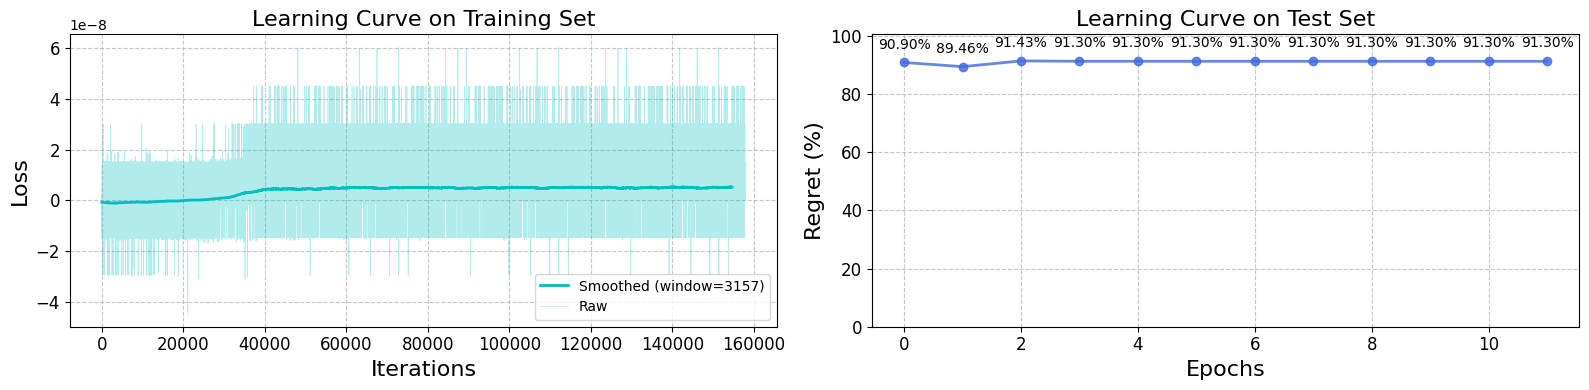

In [8]:
#############################################################################
# VISUALIZATION
#############################################################################
from matplotlib import pyplot as plt
import numpy as np


def visLearningCurve(loss_log, loss_log_regret):
    """Enhanced visualization with smoother curves and more information"""
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
    
    # Plot training loss with smoothing for readability
    n_points = len(loss_log)
    
    # Apply smoothing for large datasets
    if n_points > 100:
        window_size = max(10, n_points // 50)
        smoothed_loss = np.convolve(loss_log, np.ones(window_size)/window_size, mode='valid')
        x_axis = np.arange(len(smoothed_loss))
        ax1.plot(x_axis, smoothed_loss, color="c", lw=2, label=f"Smoothed (window={window_size})")
        # Also plot the raw data with transparency
        ax1.plot(loss_log, color="c", lw=0.5, alpha=0.3, label="Raw")
        ax1.legend()
    else:
        # For smaller datasets, just plot the raw data
        ax1.plot(loss_log, color="c", lw=2)
    
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iterations", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Draw plot for regret on test set
    epochs = np.arange(len(loss_log_regret))
    ax2.plot(epochs, [r*100 for r in loss_log_regret], 
             color="royalblue", marker='o', ls="-", alpha=0.8, lw=2)
    
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, max(50, max([r*100 for r in loss_log_regret])*1.1))  # Dynamic y-limit
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret (%)", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Add values to points
    for i, r in enumerate(loss_log_regret):
        ax2.annotate(f"{r*100:.2f}%", 
                     (i, r*100),
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center')
    
    plt.tight_layout()
    # plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    # print("Saved learning curves to 'learning_curves.png'")
    plt.show()

print("\nVisualizing learning curves...")
visLearningCurve(loss_log, loss_log_regret)

### 回测

In [12]:
from train import trainModel
from config import NUM_EPOCHS, BATCH_SIZE, LR, LSTM_SAVE_DIR
import pyepo
import torch 
import os

lstm_save_path = os.path.join(LSTM_SAVE_DIR, "trial_7_assets.pt")
lstm_eval = TwoLayerLSTM(k=K, hidden_dim=HIDDEN_DIM, lstm_hidden_dim=LSTM_HIDDEN_DIM, dropout_rate=DROPOUT_RATE).to(DEVICE)
checkpoint = torch.load(lstm_save_path, map_location=DEVICE, weights_only=False)
lstm_eval.load_state_dict(checkpoint['model_state_dict'])
print("Model architecture after training:")
for name, param in lstm_eval.named_parameters():
    print(f"{name:30s} | Shape: {param.data.shape} | Parameters: {param.numel()} | require_grad: {param.requires_grad}")
    print(f"Mean Value: {param.data.mean()} | Grad: {param.grad}")
    print("-" * 80)

Model architecture after training:
lstm.weight_ih_l0              | Shape: torch.Size([256, 21]) | Parameters: 5376 | require_grad: True
Mean Value: -0.0001790947571862489 | Grad: None
--------------------------------------------------------------------------------
lstm.weight_hh_l0              | Shape: torch.Size([256, 64]) | Parameters: 16384 | require_grad: True
Mean Value: -0.00044822879135608673 | Grad: None
--------------------------------------------------------------------------------
lstm.bias_ih_l0                | Shape: torch.Size([256]) | Parameters: 256 | require_grad: True
Mean Value: 0.006747560575604439 | Grad: None
--------------------------------------------------------------------------------
lstm.bias_hh_l0                | Shape: torch.Size([256]) | Parameters: 256 | require_grad: True
Mean Value: 0.005963595118373632 | Grad: None
--------------------------------------------------------------------------------
fc_layers.0.weight             | Shape: torch.Size([6

In [13]:
import numpy as np
# set lstm to evaluation mode
lstm_eval.eval()

pred_returns = [] # predicted returns
with torch.no_grad():
    for x, _, _, _ in loader_test:
        # 1. 预测 returns
        x = x.to(DEVICE)                      # (batch_size, N, lookback, k)
        pred_return = lstm_eval(x)                   # (batch_size, N)
        pred_return = pred_return.cpu().numpy()             # 转成ndarray
        pred_returns.append(pred_return)

pred_returns = np.vstack(pred_returns) # (T, N)
print(f"预测的收益率矩阵形状是: {pred_returns.shape}")

预测的收益率矩阵形状是: (26202, 7)


In [14]:
feats_test = np.load("test_data/features_crypto_data.npy")
print(f"测试集feature的形状是: {feats_test.shape}")

测试集feature的形状是: (26202, 7, 21)


In [15]:
### 优化器
from config import PRECOMPUTE_BATCH_SIZE, LOOKBACK, PADDING_METHOD
from batch_runner import process_and_combine_shared


#dataset_dict_test = process_and_combine_shared(feats_test, pred_returns, batch_size=PRECOMPUTE_BATCH_SIZE, **params)
from test_regret import sequential_solutions

positions=sequential_solutions(predmodel=lstm_eval,params_testing=params_testing, dataloader=loader_test)

Testing Solutions: 100%|██████████| 3276/3276 [00:16<00:00, 192.95batch/s]


In [16]:
# 测试集仓位
#positions = dataset_dict_test["sols"]
positions=np.array(positions)
print(f"测试集仓位的形状是: {positions.shape}")

测试集仓位的形状是: (26202, 7)


In [17]:
pnl_series = []
for i in range(len(positions)):
    pnl = np.nansum(positions[i] * test_dataset_dict["costs"][i])
    pnl_series.append(pnl)
print(f"pnl series的长度是: {len(pnl_series)}")

pnl series的长度是: 26202


### Visualize Cumulative Pnl

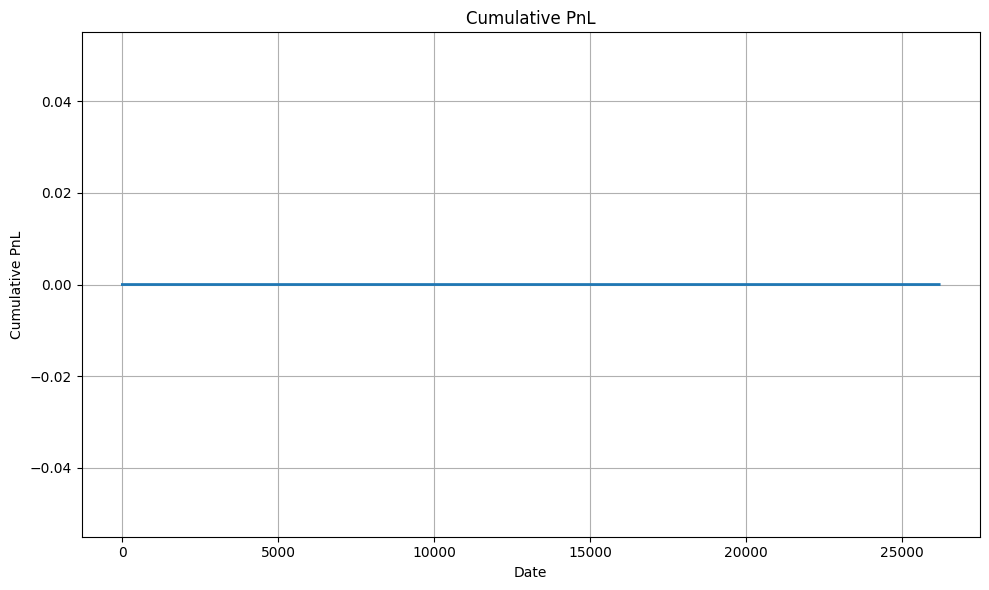

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_cum_pnl_series(pnl_series, title='Cumulative PnL', figsize=(10, 6)):
    """
    绘制累计 PnL 曲线。

    参数
    -----
    pnl_series : pandas.Series
        每期的 PnL 序列，索引为日期或时间点。
    title : str, optional
        图表标题，默认 'Cumulative PnL'。
    figsize : tuple, optional
        图表大小，默认为 (10, 6)。
    """
    # 计算累计 PnL
    cum_pnl = pd.Series(pnl_series).cumsum()

    # 绘图
    plt.figure(figsize=figsize)
    plt.plot(np.arange(len(cum_pnl)), cum_pnl.values, linewidth=2)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative PnL')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_cum_pnl_series(pnl_series)


In [19]:
positions[0]

array([0., 0., 0., 0., 0., 0., 0.])